In [1]:
import pandas as pd
import geopandas as gpd
import folium
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
nueces_shape = gpd.read_file('Data/shapefiles EJ/EJSCREEN_shape.shp')

In [7]:
# filter for low income percent at or above state average
shape_filter = nueces_shape[nueces_shape['LOWINCPCT'] >= 0.34]

In [13]:
shape_filter.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 140 entries, 0 to 267
Columns: 233 entries, ID to geometry
dtypes: float64(55), geometry(1), int64(122), object(55)
memory usage: 255.9+ KB


In [15]:
shape_filter

ID STATE_NAME ST_ABBREV      CNTY_NAME  REGION  ACSTOTPOP  \
0    483550005001      Texas        TX  Nueces County       6        422   
1    483550005002      Texas        TX  Nueces County       6        314   
2    483550006011      Texas        TX  Nueces County       6        903   
3    483550006012      Texas        TX  Nueces County       6        451   
4    483550006013      Texas        TX  Nueces County       6        583   
..            ...        ...       ...            ...     ...        ...   
249  483550061002      Texas        TX  Nueces County       6       1368   
263  483550063001      Texas        TX  Nueces County       6        418   
264  483550063002      Texas        TX  Nueces County       6       2100   
266  483550064002      Texas        TX  Nueces County       6        129   
267  483550064003      Texas        TX  Nueces County       6       1959   

     ACSIPOVBAS  ACSEDUCBAS  ACSTOTHH  ACSTOTHU  ...  NPL_CNT  TSDF_CNT  \
0           384         283       177       260  ...        0         0   
1           314         178       141       217  ...        0         0   
2           903         640       268       268  ...        0         0   
3           451         249       185       220  ...        0         0   
4           583         361       254       388  ...        0         0   
..          ...         ...       ...       ...  ...      ...       ...   
249        1360         997       498       591  ...        0         0   
263         345         290       147       560  ...        1         6   
264        2100        1170       778       844  ...        0         0   
266         129         129        87       185  ...        0         0   
267         602        1743       440       528  ...        0         0   

     EXCEED_COU  EXCEED_C_1  Exceed_C_2  Exceed_C_3  \
0             9          10           7           8   
1             9           9           6           4   
2             9           9           8           7   
3             8           9           6           7   
4             7           7           5           3   
..          ...         ...         ...         ...   
249           4           4           2           1   
263           5           5           0           0   
264           4           4           3           0   
266          11          12           9          11   
267           2           9           0           8   

                          SYMBOLOGY_  Shape_Leng  Shape_Area  \
0    1-13 EJ Indexes over 80th %tile    0.035388    0.000055   
1    1-13 EJ Indexes over 80th %tile    0.029768    0.000053   
2    1-13 EJ Indexes over 80th %tile    0.040306    0.000068   
3    1-13 EJ Indexes over 80th %tile    0.025767    0.000037   
4    1-13 EJ Indexes over 80th %tile    0.031947    0.000044   
..                               ...         ...         ...   
249  1-13 EJ Indexes over 80th %tile    0.066250    0.000203   
263  1-13 EJ Indexes over 80th %tile    0.775194    0.010158   
264  1-13 EJ Indexes over 80th %tile    0.091535    0.000337   
266  1-13 EJ Indexes over 80th %tile    0.038206    0.000076   
267  1-13 EJ Indexes over 80th %tile    0.031464    0.000062   

                                              geometry  
0    POLYGON ((-97.42766 27.79678, -97.42755 27.796...  
1    POLYGON ((-97.42232 27.80389, -97.42221 27.804...  
2    POLYGON ((-97.43137 27.78634, -97.43135 27.786...  
3    POLYGON ((-97.44818 27.79319, -97.44802 27.793...  
4    POLYGON ((-97.44041 27.79477, -97.44008 27.795...  
..                                                 ...  
249  POLYGON ((-97.80322 27.58334, -97.80288 27.583...  
263  POLYGON ((-97.56151 27.84255, -97.56150 27.842...  
264  POLYGON ((-97.59294 27.85582, -97.59240 27.856...  
266  POLYGON ((-97.41110 27.80162, -97.41091 27.801...  
267  POLYGON ((-97.40306 27.79250, -97.40305 27.793...  

[140 rows x 233 columns]

Columns I want to look at:

ID  
LOWINCPCT  
PTSDF  
RSEI_AIR  
NO2  
PWDIS    
geometry

In [31]:
nueces_inc_fil = shape_filter[['ID', 'LOWINCPCT', 'PTSDF', 'RSEI_AIR', 'NO2', 'PWDIS', 'geometry']]
nueces_inc_fil.loc[:, 'LOWINCPCT'] = nueces_inc_fil['LOWINCPCT'] *100

In [33]:
nueces_inc_fil

ID   LOWINCPCT     PTSDF      RSEI_AIR        NO2       PWDIS  \
0    483550005001   71.093750  5.384634  21070.150210  12.500319   11.207385   
1    483550005002   49.681529  4.958068  12963.414430  12.295400   12.555535   
2    483550006011   65.116279  4.245714  19336.005140  13.576175    8.334481   
3    483550006012   64.745011  5.773051  22627.257970  12.295400    4.457116   
4    483550006013   51.629503  5.130289  30940.304700  12.295400    5.544585   
..            ...         ...       ...           ...        ...         ...   
249  483550061002   53.676471  0.652535   1194.690767   7.897080  699.809013   
263  483550063001   66.956522  2.502766  18796.695140  10.382728   27.734704   
264  483550063002   61.380952  0.744199   6387.039007   8.451861    1.427203   
266  483550064002  100.000000  2.863687   7017.987275  12.807699   28.141930   
267  483550064003   46.013289  2.494296   5967.750483  13.934760   11.219544   

                                              geometry  
0    POLYGON ((-97.42766 27.79678, -97.42755 27.796...  
1    POLYGON ((-97.42232 27.80389, -97.42221 27.804...  
2    POLYGON ((-97.43137 27.78634, -97.43135 27.786...  
3    POLYGON ((-97.44818 27.79319, -97.44802 27.793...  
4    POLYGON ((-97.44041 27.79477, -97.44008 27.795...  
..                                                 ...  
249  POLYGON ((-97.80322 27.58334, -97.80288 27.583...  
263  POLYGON ((-97.56151 27.84255, -97.56150 27.842...  
264  POLYGON ((-97.59294 27.85582, -97.59240 27.856...  
266  POLYGON ((-97.41110 27.80162, -97.41091 27.801...  
267  POLYGON ((-97.40306 27.79250, -97.40305 27.793...  

[140 rows x 7 columns]

In [35]:
# reprojecting CRS for geometric calculations
nueces_inc_fil_utm = nueces_inc_fil.to_crs(epsg=32614)

In [39]:
# creating a map centered on Nueces County
mymap = folium.Map(location = [27.77, -97.40], zoom_start = 11)

In [41]:
# Choropleth for No2 data
myscale = (nueces_inc_fil_utm['NO2'].quantile((0, 0.1, 0.75, 0.9, 0.98, 1))).tolist()
folium.Choropleth(
    geo_data=nueces_inc_fil_utm,   
    name='Choropleth',
    data=nueces_inc_fil_utm,       
    columns=['ID', 'NO2'],         
    key_on='feature.properties.ID', 
    fill_color='YlGnBu',           
    threshold_scale=myscale,       
    fill_opacity=1,
    line_opacity=0.2,
    legend_name='NO2 values in low-income blocks'
).add_to(mymap)

folium.GeoJson(
    data=nueces_inc_fil_utm,
    style_function=lambda feature:{
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 0.1
    },
    tooltip= folium.GeoJsonTooltip(
        fields=['NO2', 'LOWINCPCT'],
        aliases=['NO2 Concentration:', 'Low income percentage:'],
        localize=True,
        sticky=True,
    )
    
).add_to(mymap)

folium.LayerControl().add_to(mymap)
mymap

### Choropleth for different variables

In [89]:
mymap2 = folium.Map(location = [27.77, -97.40], zoom_start = 11)

In [91]:
# Scales for different variables

hazard_scale = nueces_inc_fil_utm['PTSDF'].quantile([0, 0.1, 0.75, 0.9, 0.98, 1]).tolist()
txair_scale = nueces_inc_fil_utm['RSEI_AIR'].quantile([0, 0.1, 0.75, 0.9, 0.98, 1]).tolist()
no2_scale = nueces_inc_fil_utm['NO2'].quantile([0, 0.1, 0.75, 0.9, 0.98, 1]).tolist()
dis_scale = nueces_inc_fil_utm['PWDIS'].quantile([0, 0.1, 0.75, 0.9, 0.98, 1]).tolist()



# create choropleth layers for different variables
choropleth_no2=folium.Choropleth(
    geo_data=nueces_inc_fil_utm,
    name='NO2',
    data=nueces_inc_fil_utm,
    columns=['ID', 'NO2'],
    key_on='feature.properties.ID',
    fill_color='YlGnBu',
    threshold_scale=no2_scale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='NO2 concentrations in low-income blocks'
).add_to(mymap2)

choropleth_pwdis=folium.Choropleth(
    geo_data=nueces_inc_fil_utm,
    name='PWDIS',
    data=nueces_inc_fil_utm,
    columns=['ID', 'PWDIS'],
    key_on='feature.properties.ID',
    fill_color='BuPu',
    threshold_scale=dis_scale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Wastewater discharge values in low-income blocks',
).add_to(mymap2)

choropleth_rsei=folium.Choropleth(
    geo_data=nueces_inc_fil_utm,
    name='RSEI_AIR',
    data=nueces_inc_fil_utm,
    columns=['ID', 'RSEI_AIR'],
    key_on='feature.properties.ID',
    fill_color='OrRd',
    threshold_scale=txair_scale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Toxic releases to air values in low-income blocks',
).add_to(mymap2)

choropleth_dwater=folium.Choropleth(
    geo_data=nueces_inc_fil_utm,
    name='PTSDF',
    data=nueces_inc_fil_utm,
    columns=['ID', 'PTSDF'],
    key_on='feature.properties.ID',
    fill_color='Greens',
    threshold_scale=hazard_scale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Proximity to hazardous waste in low-income blocks',
).add_to(mymap2)

# Add GeoJson with tooltips for additional information
folium.GeoJson(
    data=nueces_inc_fil_utm,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'black',
        'weight': 0.1
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['NO2', 'PWDIS', 'RSEI_AIR','PTSDF'],
        aliases=['NO2 Concentration:', 'Wastewater Discharge:', 'Toxic Release to Air', 'Hazard Waste Proximity:'],
        localize=True,
        sticky=True
    )
).add_to(mymap2)

# Add LayerControl to toggle between different layers
folium.LayerControl(collapsed=False).add_to(mymap2)

# Save or display the map
mymap2


In [86]:
# correlation analysis

correlation= nueces_inc_fil_utm['LOWINCPCT'].corr(nueces_inc_fil_utm['PTSDF'])
print(f'Correlation between low income and proximity to hazardous material: {correlation}')

Correlation between low income and proximity to hazardous material: 0.2461780815328326


In [94]:
corr_coef, p_value = pearsonr(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['PTSDF'])
print(f"Correlation coefficient: {corr_coef}")
print(f"P-value: {p_value}")

Correlation coefficient: 0.24617808153283258
P-value: 0.003368252896494447


In [67]:
# linear regression
X = nueces_inc_fil_utm[['LOWINCPCT']]  # Independent variable
y = nueces_inc_fil_utm['NO2']  # Dependent variable

model_NO2 = LinearRegression()
model_NO2.fit(X, y)

intercept_NO2 = model_NO2.intercept_
coefficient_NO2 = model_NO2.coef_[0]
print(f'Intercept: {intercept_NO2}')
print(f'Coefficient for LOWINCPCT: {coefficient_NO2}')

# Predict values
nueces_inc_fil_utm['predicted_NO2'] = model_NO2.predict(X)

Intercept: 8.682211610797932
Coefficient for LOWINCPCT: 0.03813796502379193


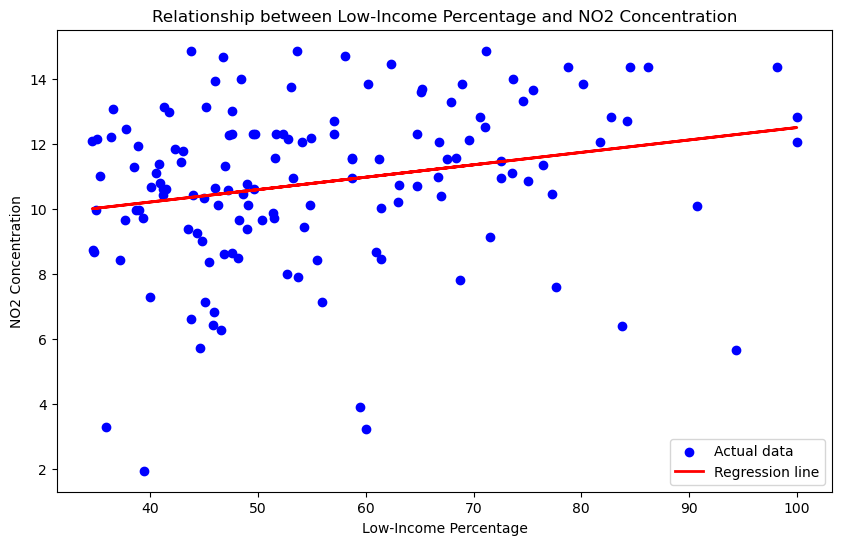

In [95]:
# scatter plot NO2
plt.figure(figsize=(10, 6))
plt.scatter(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['NO2'], color='blue', label='Actual data')

# plot the regression line
plt.plot(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['predicted_NO2'], color='red', linewidth=2, label='Regression line')

plt.title('Relationship between Low-Income Percentage and NO2 Concentration')
plt.xlabel('Low-Income Percentage')
plt.ylabel('NO2 Concentration')
plt.legend()
plt.show()

In [97]:
# linear regression
X = nueces_inc_fil_utm[['LOWINCPCT']]  
y = nueces_inc_fil_utm['RSEI_AIR']  

model = LinearRegression()
model.fit(X, y)

intercept = model.intercept_
coefficient = model.coef_[0]
print(f'Intercept: {intercept}')
print(f'Coefficient for LOWINCPCT: {coefficient}')

# predict values
nueces_inc_fil_utm['predicted_RSEI_AIR'] = model.predict(X)

Intercept: 1432.4233098472423
Coefficient for LOWINCPCT: 91.56043154845773


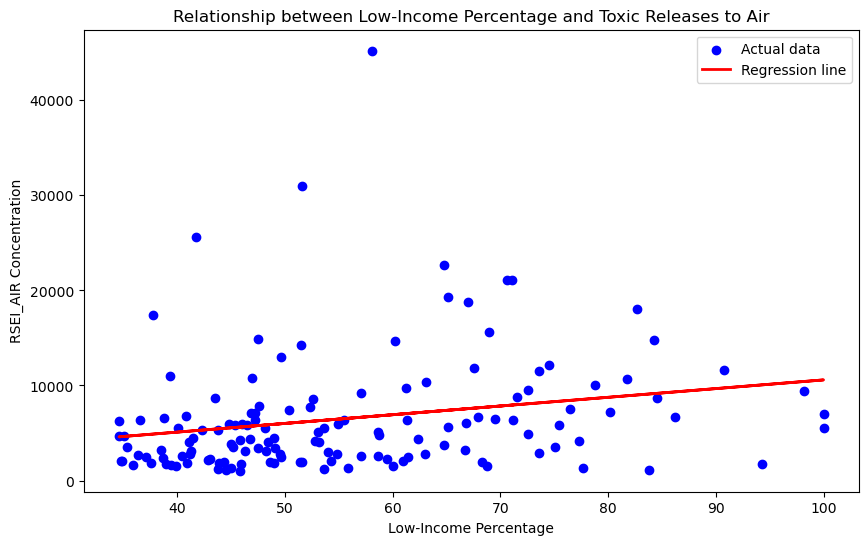

In [99]:
# scatter plot RSEI_AIR
plt.figure(figsize=(10, 6))
plt.scatter(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['RSEI_AIR'], color='blue', label='Actual data')

# plot the regression line
plt.plot(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['predicted_RSEI_AIR'], color='red', linewidth=2, label='Regression line')

plt.title('Relationship between Low-Income Percentage and Toxic Releases to Air')
plt.xlabel('Low-Income Percentage')
plt.ylabel('RSEI_AIR Concentration')
plt.legend()
plt.show()

In [101]:
# linear regression
X = nueces_inc_fil_utm[['LOWINCPCT']]  
y = nueces_inc_fil_utm['PTSDF']  

model = LinearRegression()
model.fit(X, y)

intercept = model.intercept_
coefficient = model.coef_[0]
print(f'Intercept: {intercept}')
print(f'Coefficient for LOWINCPCT: {coefficient}')

# predict values
nueces_inc_fil_utm['predicted_PTSDF'] = model.predict(X)

Intercept: 0.7483974050339415
Coefficient for LOWINCPCT: 0.021038328171622437


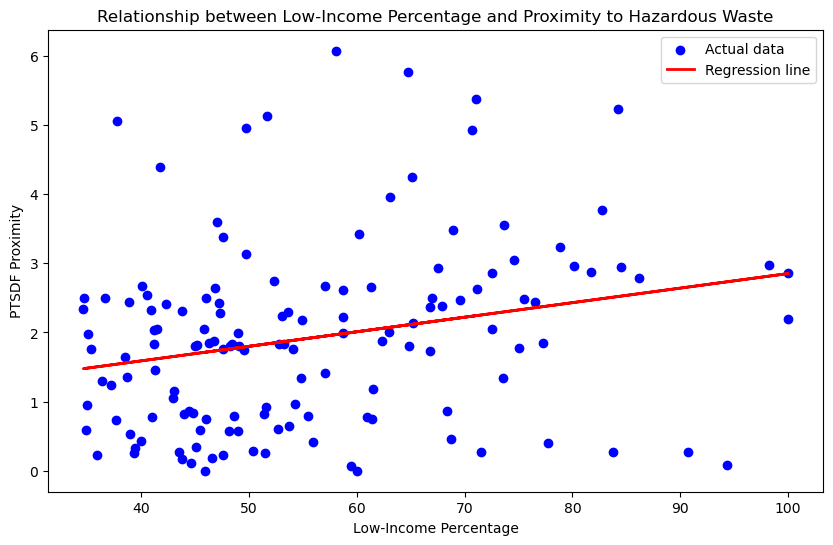

In [103]:
# scatter plot PTSDF
plt.figure(figsize=(10, 6))
plt.scatter(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['PTSDF'], color='blue', label='Actual data')

# plot the regression line
plt.plot(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['predicted_PTSDF'], color='red', linewidth=2, label='Regression line')

plt.title('Relationship between Low-Income Percentage and Proximity to Hazardous Waste')
plt.xlabel('Low-Income Percentage')
plt.ylabel('PTSDF Proximity')
plt.legend()
plt.show()

In [105]:
# linear regression
X = nueces_inc_fil_utm[['LOWINCPCT']] 
y = nueces_inc_fil_utm['PWDIS'] 

model = LinearRegression()
model.fit(X, y)

intercept = model.intercept_
coefficient = model.coef_[0]
print(f'Intercept: {intercept}')
print(f'Coefficient for LOWINCPCT: {coefficient}')

# predict values
nueces_inc_fil_utm['predicted_PWDIS'] = model.predict(X)

Intercept: 32.98400179972641
Coefficient for LOWINCPCT: -0.3239215737774859


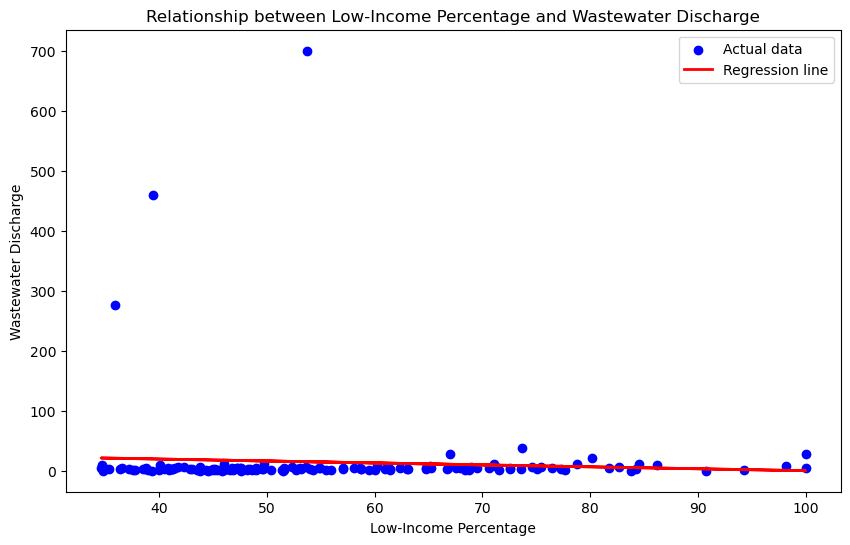

In [107]:
# scatter plot PWDIS
plt.figure(figsize=(10, 6))
plt.scatter(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['PWDIS'], color='blue', label='Actual data')

# plot the regression line
plt.plot(nueces_inc_fil_utm['LOWINCPCT'], nueces_inc_fil_utm['predicted_PWDIS'], color='red', linewidth=2, label='Regression line')

plt.title('Relationship between Low-Income Percentage and Wastewater Discharge')
plt.xlabel('Low-Income Percentage')
plt.ylabel('Wastewater Discharge')
plt.legend()
plt.show()

In [109]:
# correlation matrix with all of the income data
columns_data= ['LOWINCPCT', 'PTSDF', 'RSEI_AIR', 'NO2', 'PWDIS']
data_filter = nueces_shape[columns]

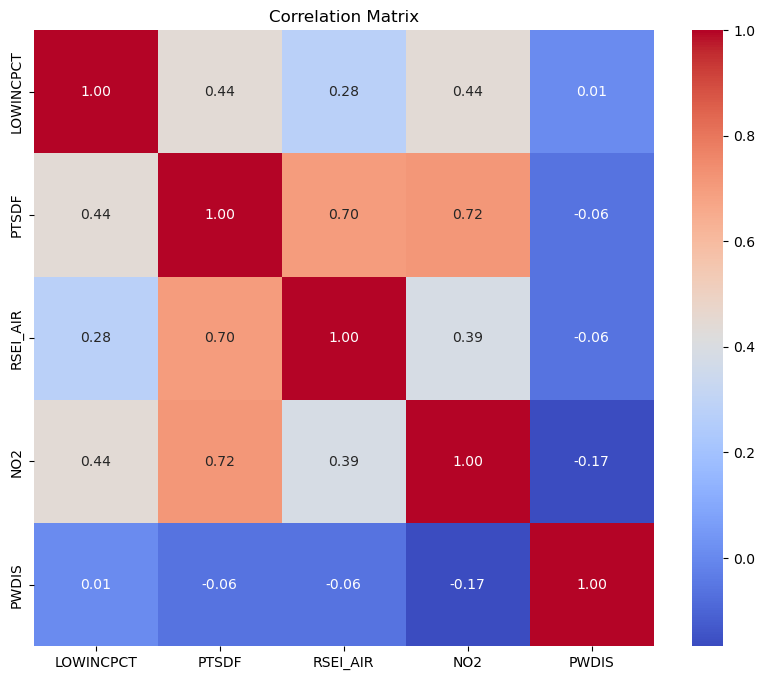

In [85]:
correlation_matrix2 = data_filter.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()